In [1]:
import argparse
import os
import sys
import torchvision
import torch
from torch.serialization import default_restore_location
from torch.distributions import Poisson
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from PIL import Image
sys.path.append('../')
import data
import models
import utils

In [2]:
diff_checkpoint_path = {
    'White-4-128': '../checkpoints/unet-128-small.pt',
}

In [13]:
dataset = 'ptceo2'
contrast = 'white'
data_path = '/scratch/sm7582/prince/sm7582/datasets/Nanoparticles/ptceo2-1024'
batch_size = 1

In [14]:
USE_CUDA = True
device = torch.device("cuda") if (
        torch.cuda.is_available() and USE_CUDA) else torch.device("cpu")

In [15]:
def load_model(checkpoint_path):
    state_dict = torch.load( checkpoint_path, map_location=lambda s,
                                l: default_restore_location(s,"cpu"))
    
    args = argparse.Namespace(
        **{**vars(state_dict["args"])})
    model = models.build_model(args).to(device)
    model.load_state_dict(state_dict["model"][0])
    model.eval()
    return model

In [16]:
net_dict = {}
for key, checkpoint_path in diff_checkpoint_path.items():
    print(key)
    net_dict[key] = load_model(checkpoint_path).to(device)

White-4-128


In [17]:
net = net_dict['White-4-128']

In [18]:
_, _, test_loader = data.build_dataset(dataset, data_path,
                                           test_batch_size=batch_size, rotation_aug = False,
                                           contrast = contrast)

In [19]:
test_dataset = test_loader.dataset;

In [20]:
len(test_dataset)

280

In [21]:
def visualize_denoising(list_of_images, 
                        labels = ['clean', 'noisy', 'denoised'], 
                        figsize = (20, 10), 
                        vmax = 1.0, vmin = 0.0, psnr = True):
    fig, axes = plt.subplots(nrows=1, ncols=len(labels), sharex = True, sharey = True, figsize = figsize)
    axes = np.ravel(axes)
    
    clean = list_of_images[0]
    for ax, image, label in zip(axes, list_of_images, labels):
        ax.imshow(image.data.cpu().numpy()[0, 0], cmap='gray', vmax=vmax, vmin = vmin)
        if psnr:
            psnr = utils.psnr(clean, image)
            ax.set_title(f"{label} {round(psnr, 2)}")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()

/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/ext3/anaconda3/lib/python3.8/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


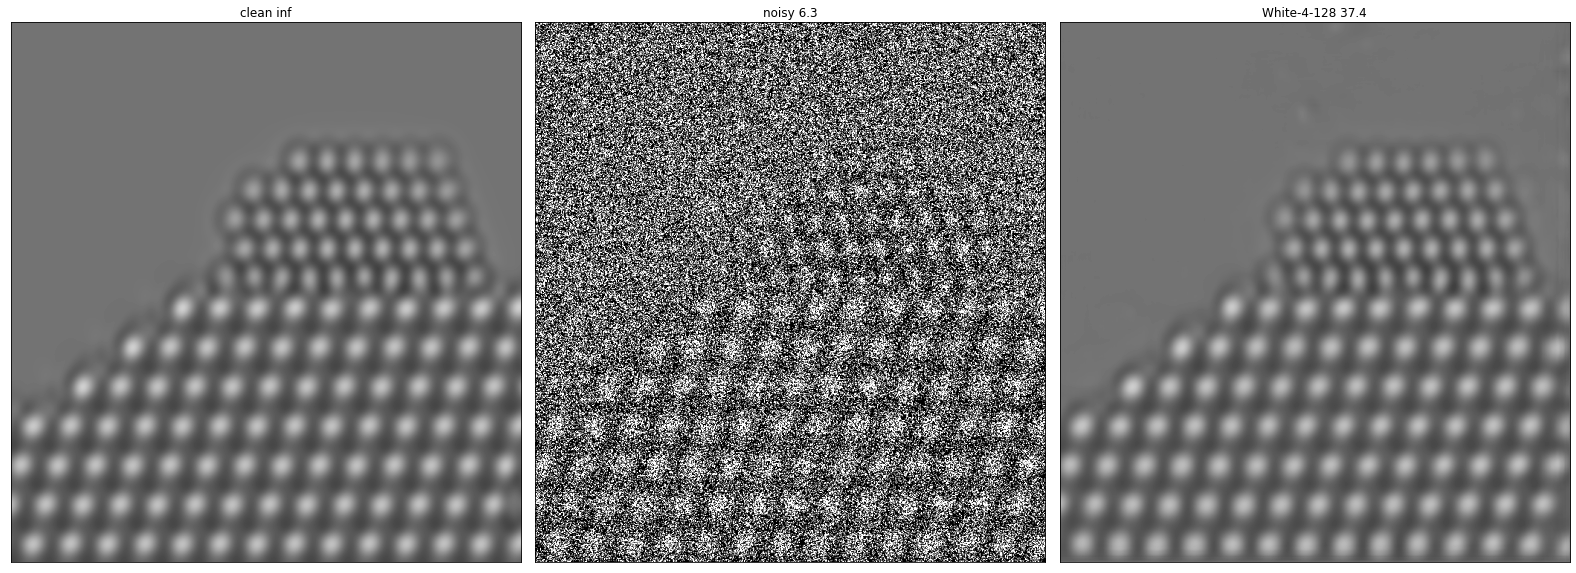

In [22]:
n = 25
x = test_dataset[n]

clean = x['image'].to(device).unsqueeze(0)
noisy = Poisson(clean).sample()

denoised = {}
with torch.no_grad():
    for key, net in net_dict.items():
        denoised[key] = net(noisy)


visualize_denoising([clean, noisy] + list(denoised.values()), 
                            vmax = 1, vmin = 0,
                            labels = ['clean', 'noisy'] + list(denoised.keys()), figsize = (22, 15))

plt.show()

# Likelihood 

In [12]:
chosen_net_name = 'White-4-128'

In [15]:
def logfactorial(n):
    if n <= 5:
        return np.log(np.math.factorial(int(n)))
    else:
        return np.log(n) * n - np.log(n)

In [16]:
def log_likelihood(base, noisy):
    l = -base
    l += noisy * np.log(base)
    
    sh = noisy.shape
    noisy = noisy.reshape(-1)
    logfact = np.zeros_like(noisy)
    
    for i, n in enumerate(noisy):
        n = np.round(n)
        logfact[i] = logfactorial(n)
        
    logfact = logfact.reshape(*sh)
    
    return l - logfact

In [17]:
noisy = noisy[0,0].data.cpu().numpy()
clean = clean[0,0].data.cpu().numpy()

In [18]:
denoised_np = denoised[chosen_net_name][0,0].data.cpu().numpy()

In [19]:
l = log_likelihood(clean, noisy)
ld = log_likelihood(denoised_np, noisy)

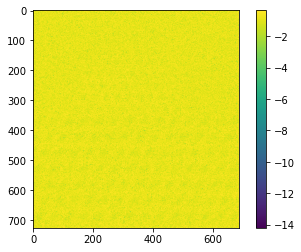

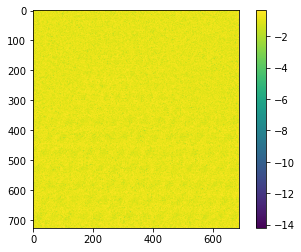

In [20]:
plt.imshow(l)
plt.colorbar()
plt.show()

plt.imshow(ld)
plt.colorbar()
plt.show()

# Locate Atoms

In [21]:
import skimage
from skimage.feature import blob_log, canny
from skimage import io, transform
from skimage.draw import circle
from skimage.morphology import disk, dilation, erosion, closing
from numpy import ma

In [22]:
def log_likelihood_sn(base, noisy):
    l = -base
    l += noisy * np.log(base)
    
    logfact = logfactorial(np.round(noisy))
    
    return l - logfact

In [23]:
def compute_likelihood_masks(base, noisy, vaccum_lambda = 0.45, vaccum_mask = None):
    
    blobs= blob_log(base, max_sigma=20, num_sigma=10, threshold=0.03)
    blobs[:, 2] = blobs[:, 2] * np.sqrt(2)
    
    mask = ma.array(base.copy(), mask=False)
    l_atom = np.zeros_like(base) + np.nan
    l_vaccum = np.zeros_like(base) + np.nan
    
    atom_lambda_image = np.zeros_like(base) + np.nan
    atom_lambda_std_image = np.zeros_like(base) + np.nan
    
    atom_count = np.zeros_like(base) + np.nan
    
    for blob in blobs:
        y, x, r = blob
        xx, yy = circle(*blob)
        
        atom_lambda = 0
        count = 0
        temp = []
        for xxx, yyy in zip(xx, yy):
            if xxx < base.shape[0] and yyy < base.shape[1]:
                temp.append(base[xxx, yyy])
                count += 1
                
        atom_lambda = np.mean(temp)
        atom_lambda_std = np.std(temp)
        
        temp_atom = 0
        temp_vaccum = 0
        count = 0
        
        for xxx, yyy in zip(xx, yy):
            if xxx < base.shape[0] and yyy < base.shape[1]:
                mask.mask[xxx, yyy] = True
                
                temp_atom += log_likelihood_sn(atom_lambda, noisy[xxx, yyy])
                temp_vaccum += log_likelihood_sn(vaccum_lambda, noisy[xxx, yyy])
                count += 1

        temp_atom /= count
        temp_vaccum /= count
        
        for xxx, yyy in zip(xx, yy):
            if xxx < base.shape[0] and yyy < base.shape[1]:
                l_atom[xxx, yyy] = temp_atom
                l_vaccum[xxx, yyy] = temp_vaccum
                atom_count[xxx, yyy] = count
                atom_lambda_image[xxx, yyy] = atom_lambda
                atom_lambda_std_image[xxx, yyy] = atom_lambda_std
                
    
    temp_atom = 0
    temp_vaccum = 0
    count = 0
    
    atom_lambda = np.nanmean(atom_lambda_image)
    
    for xxx in range(0, base.shape[0]):
        for yyy in range(0, base.shape[1]):
            
            if vaccum_mask[xxx, yyy] == 1:
                temp_atom += log_likelihood_sn(atom_lambda, noisy[xxx, yyy])
                temp_vaccum += log_likelihood_sn(vaccum_lambda, noisy[xxx, yyy])
                count += 1
    
    temp_atom /= count
    temp_vaccum /= count
    
    for xxx in range(0, base.shape[0]):
        for yyy in range(0, base.shape[1]):
            
            if vaccum_mask[xxx, yyy] == 1:
                l_atom[xxx, yyy] = temp_atom
                l_vaccum[xxx, yyy] = temp_vaccum
            
    return l_vaccum, l_atom, blobs, atom_count, atom_lambda_image, atom_lambda_std_image

In [24]:
def get_vaccum_mask(data, show_images = False):
    blobs= blob_log(data, max_sigma=20, num_sigma=10, threshold=0.03)
    blobs[:, 2] = blobs[:, 2] * np.sqrt(2)
    
    if show_images:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
        axes[0].imshow(data, cmap='gray')
        for blob in blobs:
            y, x, r = blob
            axes[0].add_patch(plt.Circle((x, y), r, color='red', linewidth=2, fill=False))
        axes[0].set_axis_off()
        axes[0].set_title('Blob Detection')
    
    atoms = np.zeros_like(data)
    for blob in blobs:
        y, x, r = blob
        xx, yy = circle(*blob)
        for xxx, yyy in zip(xx, yy):
            if xxx < data.shape[0] and yyy < data.shape[1]:
                atoms[xxx, yyy] = 1
                
    dilated = dilation(atoms, disk(25))
    
    if show_images:
        axes[1].imshow(atoms, cmap='gray')
        axes[1].set_axis_off()
        axes[1].set_title('Atoms')
        axes[2].imshow(1-dilated, cmap='gray')
        axes[2].set_axis_off()
        axes[2].set_title('Vaccum Mask')
    
    return 1-dilated

In [25]:
data = denoised_np

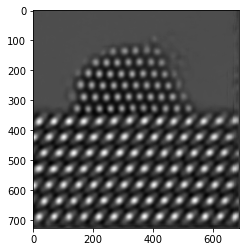

In [26]:
plt.imshow(denoised_np, cmap='gray')

<ipython-input-24-8487efb2ed6b>:17: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  xx, yy = circle(*blob)


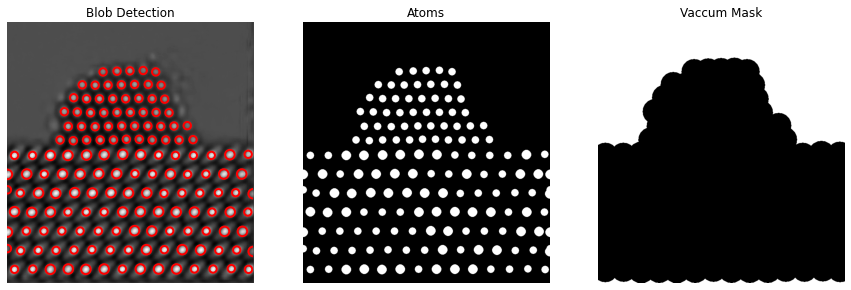

In [27]:
vaccum_mask = get_vaccum_mask(denoised_np, show_images = True)

In [28]:
vaccum_lambda = np.mean(denoised_np[0:150, 0:600])
print(vaccum_lambda)

0.44980964


In [29]:
l_vaccum, l_atom, blobs, atom_count, atom_lambda_image, atom_lambda_std_image = compute_likelihood_masks(denoised_np, noisy, vaccum_lambda, vaccum_mask)

<ipython-input-23-5347837d6238>:17: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  xx, yy = circle(*blob)


In [30]:
gt_l_vaccum, gt_l_atom, _, _, _, _ = compute_likelihood_masks(clean, noisy, vaccum_lambda, vaccum_mask)

<ipython-input-23-5347837d6238>:17: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  xx, yy = circle(*blob)


([], [])

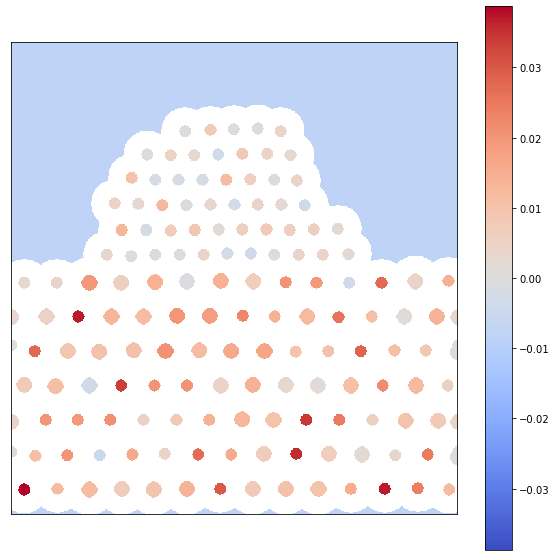

In [31]:
plt.figure(figsize = (10, 10))
t = l_vaccum - l_atom
t = -1*t
climit = 0.90*np.nanmax(np.abs(t))

plt.imshow(t, cmap='coolwarm', vmax = climit, vmin=-climit)
plt.colorbar()

plt.xticks([])
plt.yticks([])

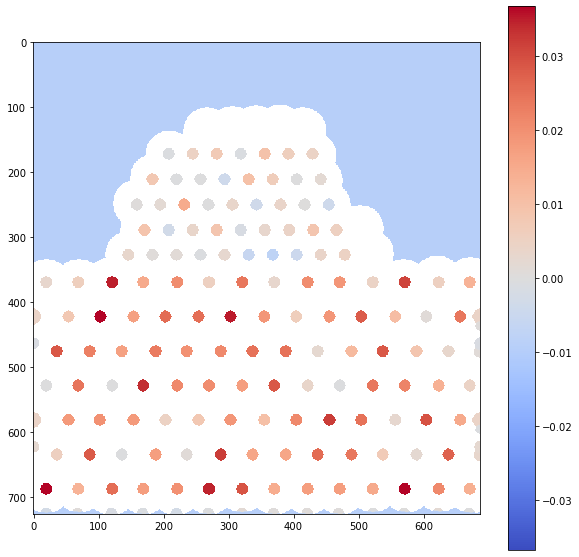

In [32]:
plt.figure(figsize = (10, 10))
t = gt_l_vaccum - gt_l_atom
t = -1*t
climit = 0.90*np.nanmax(np.abs(t))

plt.imshow(t, cmap='coolwarm', vmax = climit, vmin=-climit)
plt.colorbar()

# Plot in the paper

In [33]:
l_denoised =  l_atom - l_vaccum 
climit = 0.90*np.nanmax(np.abs(l_denoised))

l_clean =  gt_l_atom - gt_l_vaccum
climit = max( climit, 0.90*np.nanmax(np.abs(l_clean)) )

In [34]:
0.90*np.nanmax(np.abs(l_clean))

0.03674497604370117

In [35]:
0.90*np.nanmax(np.abs(l_denoised))

0.038699555397033694

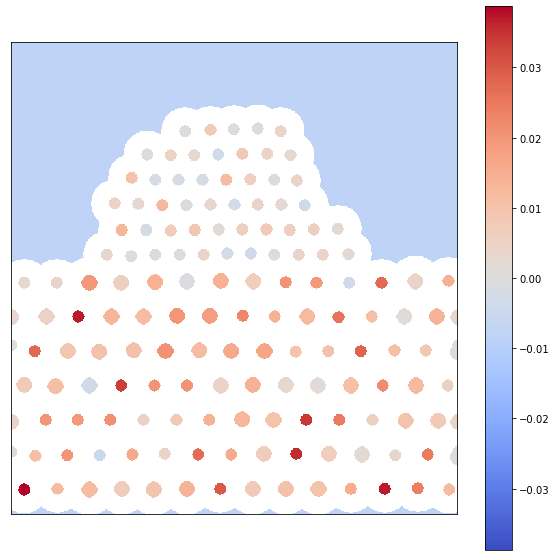

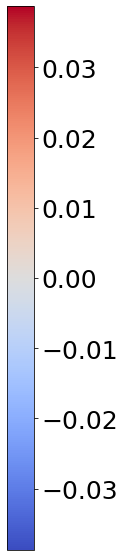

In [36]:
plt.figure(figsize = (10, 10))


x = plt.imshow(l_denoised, cmap='coolwarm', vmax = climit, vmin=-climit)
plt.xticks([])
plt.yticks([])

# plot the original without a colorbar
# plt.savefig('../images/likelihood_sim/l_denoised.pdf', bbox_inches='tight')

# plot a colorbar into the original to see distortion
plt.colorbar()
# plt.savefig('../images/likelihood_sim/plot_withcbar.png')

# draw a new figure and replot the colorbar there
fig, ax = plt.subplots(figsize=(10,10))
cbar = plt.colorbar(x,ax=ax)
ax.remove()
cbar.ax.tick_params(labelsize=25)
# plt.savefig('../images/likelihood_sim/colorbar.pdf', bbox_inches='tight')

([], [])

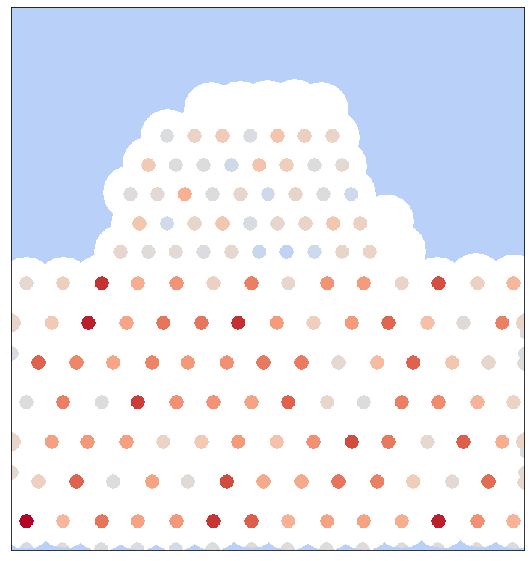

In [38]:
plt.figure(figsize = (10, 10))


x = plt.imshow(l_clean, cmap='coolwarm', vmax = climit, vmin=-climit)
plt.xticks([])
plt.yticks([])

# plot the original without a colorbar
# plt.savefig('../images/likelihood_sim/l_clean.pdf', bbox_inches='tight')

([], [])

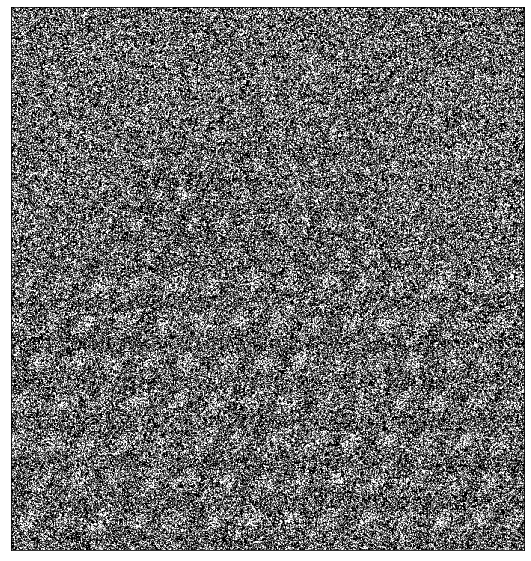

In [39]:
plt.figure(figsize = (10, 10))


x = plt.imshow(noisy, cmap='gray', vmax=1.0, vmin=0.0)
plt.xticks([])
plt.yticks([])

# plot the original without a colorbar
# plt.savefig('../images/likelihood_sim/noisy.pdf', bbox_inches='tight')

([], [])

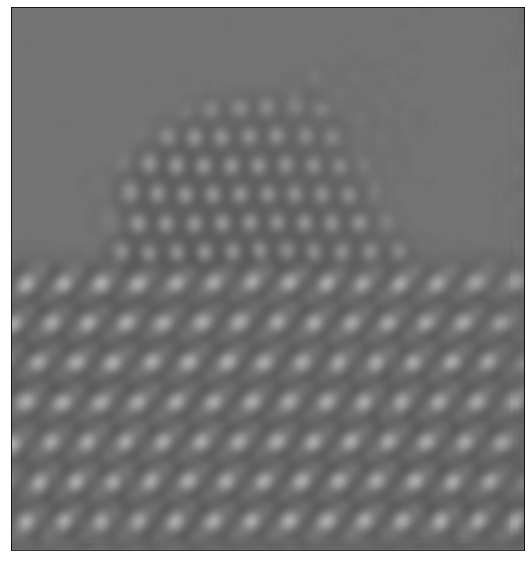

In [41]:
plt.figure(figsize = (10, 10))


x = plt.imshow(denoised_np, cmap='gray', vmax=1.0, vmin=0.0)
plt.xticks([])
plt.yticks([])

# plot the original without a colorbar
# plt.savefig('../images/likelihood_sim/denoised.pdf', bbox_inches='tight')

([], [])

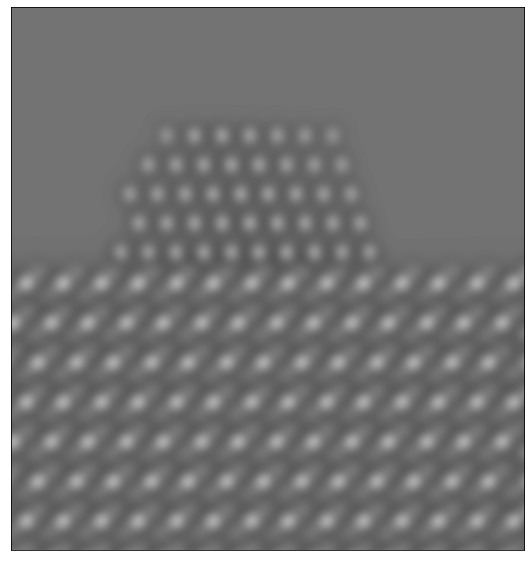

In [42]:
plt.figure(figsize = (10, 10))


x = plt.imshow(clean, cmap='gray', vmax=1.0, vmin=0.0)
plt.xticks([])
plt.yticks([])

# plot the original without a colorbar
# plt.savefig('../images/likelihood_sim/clean.pdf', bbox_inches='tight')